In [ ]:
import * from utils            

tens = [10,20,30,40,50,60,70,80,90,100,110,120,130,140]
alpha_all = np.zeros((len(tens), 100))

rat_name = 'R'
mod_name = '2'
sess_name = 'OF'
day_name = 'day1'

nums = 3
angs = np.zeros((len(tens), nums))
xlen = np.zeros((len(tens), nums))
ylen = np.zeros((len(tens), nums))
score1 = np.zeros((len(tens), nums))
score2 = np.zeros((len(tens), nums))
nn = -1
dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

sspikes_all, xx,yy = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                 bSmooth = True, bSpeed = True)[:3]
spikes_all = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure', bSmooth = False, bSpeed = True)[0]


In [ ]:

num_neurons_all = len(spikes_all[0,:])
for nn, n  in enumerate(tens):   
    combinations_sample = list(itertools.islice(random_combinations(np.arange(num_neurons_all), n), nums))
    for j, comb  in enumerate(combinations_sample):        
        sspikes = sspikes_all[:, comb].copy()
        spikes = spikes_all[:, comb].copy()
        num_neurons = len(sspikes[0,:])            
        times_cube = np.arange(0,len(sspikes[:,0]),num_times)
        movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
        movetimes = times_cube[movetimes]

        dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim)
        indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                            n_points, 1, metric)
        dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
        X = squareform(pdist(dim_red_spikes_move_scaled, metric))
        knn_indices = np.argsort(X)[:, :nbs]
        knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
        sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
        rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
        result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
        result.eliminate_zeros()
        transpose = result.transpose()
        prod_matrix = result.multiply(transpose)
        result = (result + transpose - prod_matrix)
        result.eliminate_zeros()
        d = result.toarray()
        d = -np.log(d)
        np.fill_diagonal(d,0)

        persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)    

        diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
        cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
        dists_land = persistence["dperm2all"] # the pairwise distance between the points 
        births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
        deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
        deaths1[np.isinf(deaths1)] = 0
        lives1 = deaths1-births1 # the lifetime for the 1-dim classes
        iMax = np.argsort(lives1)
        coords1 = np.zeros((num_circ, len(indstemp)))
        threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
        for c in ph_classes:
            cocycle = cocycles[iMax[-(c+1)]]
            coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)

        num_neurons = len(sspikes[0,:])
        centcosall = np.zeros((num_neurons, 2, n_points))
        centsinall = np.zeros((num_neurons, 2, n_points))
        dspk = preprocessing.scale(sspikes[movetimes[indstemp],:])

        for neurid in range(num_neurons):
            spktemp = dspk[:, neurid].copy()
            centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
            centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)
        times = np.where(np.sum(spikes>0, 1)>=1)[0]
        dspk = preprocessing.scale(sspikes)
        sspikes = sspikes[times,:]
        dspk = dspk[times,:]

        a = np.zeros((len(sspikes[:,0]), 2, num_neurons))
        for n in range(num_neurons):
            a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

        c = np.zeros((len(sspikes[:,0]), 2, num_neurons))
        for n in range(num_neurons):
            c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

        mtot2 = np.sum(c,2)
        mtot1 = np.sum(a,2)
        coords = np.arctan2(mtot2,mtot1)%(2*np.pi)

        m1b_1, m2b_1, xedge,yedge = get_ang_hist(coords[:,0], 
            coords[:,1], xx[times],yy[times])
        p1b_1, f1 = fit_sine_wave(m1b_1)
        p2b_1, f2 = fit_sine_wave(m2b_1)

        x,y = rot_para(p1b_1,p2b_1)
        xmin = xedge.min()
        xedge -= xmin
        xmax = xedge.max()
        ymin = yedge.min()
        yedge -= ymin
        ymax = yedge.max()

        angs[nn,j] = ((y[0]-x[0])/(2*np.pi)*360)%360
        xlen[nn,j] = 1/x[2]*xmax
        ylen[nn,j] = 1/y[2]*ymax
        score1[nn,j] = f1
        score2[nn,j] = f2
        print(angs[nn,j])
np.savez('Toroidal_topology_grid_cell_data/Results/toroidal_classification', 
         angs=angs, xlen=xlen, ylen=ylen, score1=score1, score2=score2)



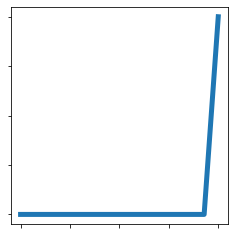

In [75]:
tens = [10, 20, 30, 40, 50, 60, 70, 80, 90,100,110,120,130,140]

f = np.load('Toroidal_topology_grid_cell_data/Results/toroidal_classification.npz', allow_pickle = True)
angs = f['angs']
xlen = f['xlen']
ylen = f['ylen']
score1 = f['score1']
score2 = f['score2']
f.close()

plt.figure()
ax = plt.axes()
successes = np.zeros(len(tens))
fit_thresh = 0.25
for i in range(len(tens)):
    successes[i] = np.sum(((angs[i,:]<70) & 
                           (angs[i,:]>50) &
                           (np.abs(1-xlen[i,:]/ylen[i,:])<0.25) &
                           (score1[i,:]<fit_thresh) & 
                           (score2[i,:]<fit_thresh)))
    
ax.plot(np.concatenate(([0], np.divide(tens,140)))*100,
        np.concatenate(([0], successes/nums*100)), label='0.25', lw = 5)
ax.set_xticks(np.divide([0,35,70,105,140],140)*100)
ax.set_xticklabels(('','','','',''))
ax.set_yticks((0,25,50,75,100))
ax.set_yticklabels(('','','','',''))
ax.set_aspect('equal', 'box')